In [13]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("mammoreport.csv")
df.head()

,Features,Birads
0,Soft tissue mass lesion (23 x 20 mm) with spic...,4
1,Parenchyma is predominantly FATTY.No distinctl...,1
2,Parenchyma is predominantly GLANDULAR. No dist...,1
3,Parenchyma is predominantly GLANDULAR. No dist...,2
4,Parenchyma is GLANDULAR and FATTY. Small subce...,2


# Preprocessing
Cleaning and converting the dataset for processing with ML Models

### Generating target feature based on birad score for Binary classification

In [15]:
birads = df["Birads"].copy()
for i in range(0, len(birads)):
  if birads.iloc[i] > 4:
    birads.iloc[i] = 1
  else:
    birads.iloc[i] = 0
Y = birads.to_numpy()

### Converting to string of lowercase and striping spaces

In [16]:
df["Features"] = df["Features"].astype(str)
df["Features"] = df["Features"].str.lower()
df["Features"] = df["Features"].str.strip()
df.head()

,Features,Birads
0,soft tissue mass lesion (23 x 20 mm) with spic...,4
1,parenchyma is predominantly fatty.no distinctl...,1
2,parenchyma is predominantly glandular. no dist...,1
3,parenchyma is predominantly glandular. no dist...,2
4,parenchyma is glandular and fatty. small subce...,2


### Removing punctuations

In [17]:
import re
df["Features"] = df["Features"].apply(lambda text: re.sub(r'[^\w\s]',' ', text))
df.head()

,Features,Birads
0,soft tissue mass lesion 23 x 20 mm with spic...,4
1,parenchyma is predominantly fatty no distinctl...,1
2,parenchyma is predominantly glandular no dist...,1
3,parenchyma is predominantly glandular no dist...,2
4,parenchyma is glandular and fatty small subce...,2


### Removing stopwords from the data

In [18]:
nltk.download('stopwords')
from nltk.corpus import stopwords

df["Features"] = df["Features"].apply(lambda text: " ".join([word for word in text.split() if word not in stopwords.words('english')]))
df.head()

[nltk_data] Downloading package stopwords to /home/raz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Features,Birads
0,soft tissue mass lesion 23 x 20 mm spiculated ...,4
1,parenchyma predominantly fatty distinctly iden...,1
2,parenchyma predominantly glandular distinctly ...,1
3,parenchyma predominantly glandular distinctly ...,2
4,parenchyma glandular fatty small subcentimeter...,2


### Lemmetizing the report data

In [19]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

def lemmetizeText(text):
    sentences = []
    for sentence in nltk.sent_tokenize(text):
        sentences.append(" ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) ]))
    return "".join(sentences)

df.loc[:,"Features"] = df.Features.apply(lemmetizeText)
df.head()

[nltk_data] Downloading package wordnet to /home/raz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/raz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Features,Birads
0,soft tissue mass lesion 23 x 20 mm spiculated ...,4
1,parenchyma predominantly fatty distinctly iden...,1
2,parenchyma predominantly glandular distinctly ...,1
3,parenchyma predominantly glandular distinctly ...,2
4,parenchyma glandular fatty small subcentimeter...,2


### Generating Vector Representation

Term Frequency was initialially tested with various SVM(SVC) with various kernal functions. But it yielded very low prediction measures. Using tfidf yielded better results.


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer()
frequencies = vectorizer.fit_transform(df['Features']).toarray()
X = frequencies

# Testing Models

### Utility functions for Report generation

In [21]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut


def get_binary_classification_measures(y_actual, y_pred):
    print('Accuracy  : ', accuracy_score(y_actual, y_pred))
    print('Precision : ', precision_score(y_actual, y_pred))
    print('Recall    : ', recall_score(y_actual, y_pred))
    print('F1 Score  : ', f1_score(y_actual, y_pred))
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.show()
    print('ROC AUC   : ', roc_auc_score(y_actual, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_actual, y_pred))
    print("***********************************************************")

def get_leave_one_out_report(classifier, binary=True, **kwargs):
    loo = LeaveOneOut()
    overall_y_test = []
    overall_y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        cf = classifier(**kwargs)
        cf.fit(X_train, y_train)
        y_pred = cf.predict(X_test)
        overall_y_test.extend(y_test)
        overall_y_pred.extend(y_pred)

    if binary:
        get_binary_classification_measures(overall_y_test, overall_y_pred)
    else:        
        print(classification_report(overall_y_test, overall_y_pred, zero_division=0))

In [22]:
%pip install scalene
%load_ext scalene

34285
34286

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Scalene: Program did not run for long enough to profile.
Scalene: Program did not run for long enough to profile.
Note: you may need to restart the kernel to use updated packages.
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


### Logistic Regression

SCALENE MAGIC
args=ScaleneArguments(cpu=True, gpu=True, memory=True, stacks=False, cpu_percent_threshold=1, cpu_sampling_rate=0.01, allocation_sampling_window=10485767, html=False, json=False, column_width=132, malloc_threshold=100, outfile=None, pid=0, profile_all=False, profile_interval=inf, profile_only='', profile_exclude='', program_path='', reduced_profile=False, use_virtual_time=False, memory_leak_detector=True, web=True, no_browser=False, port=8088, cli=False)
Accuracy  :  0.7757009345794392
Precision :  0.2222222222222222
Recall    :  0.6666666666666666
F1 Score  :  0.3333333333333333


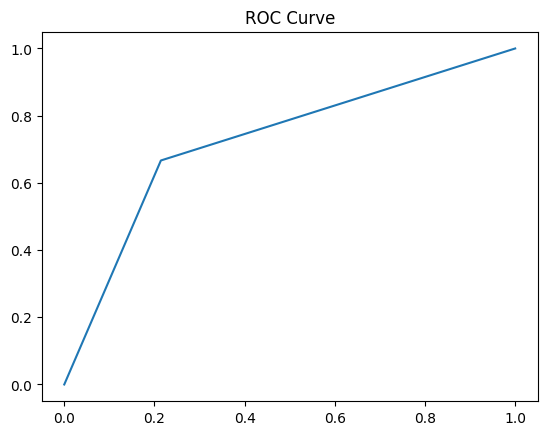

ROC AUC   :  0.726190476190476
Confusion Matrix: 
 [[77 21]
 [ 3  6]]
***********************************************************


cell='import math\nimport numpy as np\n\nclass LogisticRegression:    \n    def __init__(self, eta=0.01, max_iter=500):\n        self.weights = None\n        self.eta = eta\n        self.max_iter = max_iter\n\n    @staticmethod\n    def sigmoid(x):\n        return 1 / (1 + math.exp(-x))\n    \n    def predict(self, x_data):\n        if self.weights is None:\n            raise ValueError("Model was never trained")\n        return np.array([1 if self.sigmoid(np.dot(self.weights, x)) >= 0.5 else 0 for x in x_data])\n\n    def fit(self, x_data, y_data):\n        x_data = np.copy(x_data)\n        np.c_[x_data, np.ones(len(x_data))] \n        self.weights = np.random.rand(x_data.shape[1])\n        converged = False\n        iters = 0\n        while not converged and iters < self.max_iter:\n            converged = True\n            for i in range(len(x_data)):\n                sig = self.sigmoid(np.dot(self.weights, x_data[i]))\n                y_hat = 1 if sig >= 0.5 else 0\n                

In [23]:
%%scalene
import math
import numpy as np

class LogisticRegression:    
    def __init__(self, eta=0.01, max_iter=500):
        self.weights = None
        self.eta = eta
        self.max_iter = max_iter

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + math.exp(-x))
    
    def predict(self, x_data):
        if self.weights is None:
            raise ValueError("Model was never trained")
        return np.array([1 if self.sigmoid(np.dot(self.weights, x)) >= 0.5 else 0 for x in x_data])

    def fit(self, x_data, y_data):
        x_data = np.copy(x_data)
        np.c_[x_data, np.ones(len(x_data))] 
        self.weights = np.random.rand(x_data.shape[1])
        converged = False
        iters = 0
        while not converged and iters < self.max_iter:
            converged = True
            for i in range(len(x_data)):
                sig = self.sigmoid(np.dot(self.weights, x_data[i]))
                y_hat = 1 if sig >= 0.5 else 0
                if y_hat != y_data[i]:
                    self.weights = self.weights + (y_data[i] - sig) * self.eta * x_data[i]    
                    converged = False
            iters += 1
        return self.weights

get_leave_one_out_report(LogisticRegression)

### Perceptron

SCALENE MAGIC
args=ScaleneArguments(cpu=True, gpu=True, memory=True, stacks=False, cpu_percent_threshold=1, cpu_sampling_rate=0.01, allocation_sampling_window=10485767, html=False, json=False, column_width=132, malloc_threshold=100, outfile=None, pid=0, profile_all=False, profile_interval=inf, profile_only='', profile_exclude='', program_path='', reduced_profile=False, use_virtual_time=False, memory_leak_detector=True, web=True, no_browser=False, port=8088, cli=False)
Accuracy  :  0.794392523364486
Precision :  0.24
Recall    :  0.6666666666666666
F1 Score  :  0.3529411764705882


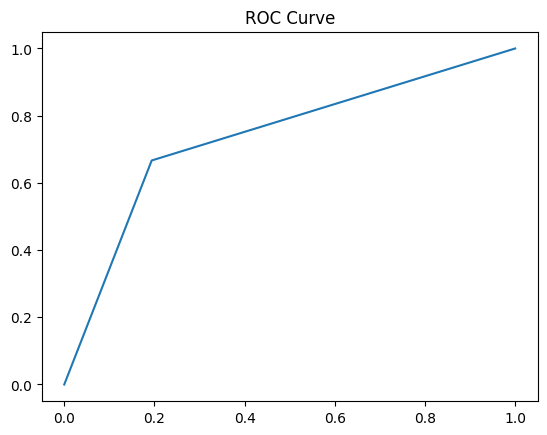

ROC AUC   :  0.7363945578231291
Confusion Matrix: 
 [[79 19]
 [ 3  6]]
***********************************************************


cell='import numpy as np\n\nclass Perceptron:\n    def __init__(self, eta=0.01, max_iter=500):\n        self.weights = None\n        self.eta = eta\n        self.max_iter = max_iter\n    \n    def predict(self, x_data):\n        if self.weights is None:\n            raise ValueError("Model was never trained")\n        return np.array([1 if np.dot(self.weights, x) > 0 else 0 for x in x_data])\n\n    def fit(self, x_data, y_data):\n        x_data = np.copy(x_data)\n        np.c_[x_data, np.ones(len(x_data))] \n        self.weights = np.random.rand(x_data.shape[1])\n        converged = False\n        iters = 0\n        while not converged and iters < self.max_iter:\n            converged = True\n            for i in range(len(x_data)):\n                y_hat = 1 if np.dot(self.weights, x_data[i]) > 0 else 0\n                if y_data[i] != y_hat:\n                  converged = False\n                  if y_data[i] == 0:\n                    self.weights -= self.eta * x_data[i]\n          

In [24]:
%%scalene
import numpy as np

class Perceptron:
    def __init__(self, eta=0.01, max_iter=500):
        self.weights = None
        self.eta = eta
        self.max_iter = max_iter
    
    def predict(self, x_data):
        if self.weights is None:
            raise ValueError("Model was never trained")
        return np.array([1 if np.dot(self.weights, x) > 0 else 0 for x in x_data])

    def fit(self, x_data, y_data):
        x_data = np.copy(x_data)
        np.c_[x_data, np.ones(len(x_data))] 
        self.weights = np.random.rand(x_data.shape[1])
        converged = False
        iters = 0
        while not converged and iters < self.max_iter:
            converged = True
            for i in range(len(x_data)):
                y_hat = 1 if np.dot(self.weights, x_data[i]) > 0 else 0
                if y_data[i] != y_hat:
                  converged = False
                  if y_data[i] == 0:
                    self.weights -= self.eta * x_data[i]
                  else:
                    self.weights += self.eta * x_data[i]
            iters += 1
        return self.weights

get_leave_one_out_report(Perceptron)